# 02 - Clusterização: K-means e Hierárquico

Este notebook executa o pré-processamento (sem a coluna de rótulo), aplica K-means e Clusterização Hierárquica com diferentes `linkage`, avalia K-means via método do cotovelo para escolha de K, e compara os resultados entre algoritmos usando métricas de clusterização.


In [2]:

# Configurações gerais
RANDOM_STATE = 42
N_JOBS = -1
N_SPLITS = 5  # k-fold
TEST_SIZE = 0.2

In [16]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)\

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import (
    StratifiedKFold, 
    StratifiedGroupKFold,
    cross_validate, 
    cross_val_predict, 
    cross_val_score,
    train_test_split
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    f1_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    make_scorer,
    classification_report
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import RobustScaler

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score




## Carregamento e preparação dos dados (sem rótulo)

Substitua `data/arquivo.csv` e ajuste a coluna do rótulo `target` para removê-la do `X` antes da clusterização.


In [11]:
sinais = pd.read_csv('../data/Sinais/sinais.csv')
print(sinais.shape)
print(sinais.head())

def extrair_metricas_do_arquivo(caminho_arquivo):
    # Carregando o arquivo JSON
    sinal = pd.read_json(caminho_arquivo)
    frames = sinal['frames']
    dados_keypoints = []

    # --- Normalização: pega keypoint id=0 do frame 0 como referência ---
    ref_x, ref_y = None, None
    for keypoint in frames[0]['keypoints']:
        if keypoint['id'] == 0:
            ref_x, ref_y = keypoint['x'], keypoint['y']
            break

    if ref_x is None:
        raise ValueError("Frame 0 não contém keypoint id=0!")

    # Iterando por todos os frames
    for frame_idx, frame_data in enumerate(frames):
        for keypoint in frame_data['keypoints']:
            if 11 <= keypoint['id'] <= 22:
                dados_keypoints.append({
                    'frame': frame_idx,
                    'id': keypoint['id'],
                    # Centralização: subtrai o ponto de referência
                    'x': keypoint['x'] - ref_x,
                    'y': keypoint['y'] - ref_y,
                    'visibility': keypoint['visibility']
                })

    # Convertendo para DataFrame
    df_keypoints = pd.DataFrame(dados_keypoints)

    # Calculando métricas para cada ID e cada atributo
    metricas = df_keypoints.groupby('id').agg({
        'x': ['mean', 'std', 'min', 'max'],
        'y': ['mean', 'std', 'min', 'max'],
        'visibility': ['mean', 'std', 'min', 'max']
    })

    # Achatando colunas
    metricas.columns = ['_'.join(col).strip() for col in metricas.columns.values]
    metricas = metricas.reset_index()

    # Criando dicionário com todas as métricas
    metricas_dict = {}
    for _, row in metricas.iterrows():
        id_keypoint = int(row['id'])
        for col in metricas.columns:
            if col != 'id':
                metricas_dict[f'id_{id_keypoint}_{col}'] = row[col]

    return metricas_dict


# --- Pipeline de extração de todos os arquivos ---
resultados = pd.DataFrame()

for idx, row in sinais.iterrows():
    caminho_arquivo = f'../data/Sinais/Sinais/{row["file_name"]}'
    try:
        metricas_arquivo = extrair_metricas_do_arquivo(caminho_arquivo)
        temp_df = pd.DataFrame([{**row, **metricas_arquivo}])
        resultados = pd.concat([resultados, temp_df], ignore_index=True)

        if idx % 10 == 0:
            print(f"Processados {idx+1} arquivos de {len(sinais)}")

    except Exception as e:
        print(f"Erro ao processar {row['file_name']}: {e}")


(2502, 7)
           file_name  width  height  duration_sec  num_frames   sinal interprete
0  Adição_AP_10.json    738    1008      4.533333         136  Adição    Alexson
1   Adição_AP_1.json    774    1006      4.766667         143  Adição    Alexson
2   Adição_AP_2.json    760    1002      4.433333         133  Adição    Alexson
3   Adição_AP_3.json    762    1000      4.933333         148  Adição    Alexson
4   Adição_AP_4.json    764    1004      4.600000         138  Adição    Alexson
Processados 1 arquivos de 2502
Processados 11 arquivos de 2502
Processados 21 arquivos de 2502
Processados 31 arquivos de 2502
Processados 41 arquivos de 2502
Processados 51 arquivos de 2502
Processados 61 arquivos de 2502
Processados 71 arquivos de 2502
Processados 81 arquivos de 2502
Processados 91 arquivos de 2502
Processados 101 arquivos de 2502
Processados 111 arquivos de 2502
Processados 121 arquivos de 2502
Processados 131 arquivos de 2502
Processados 141 arquivos de 2502
Processados 151 arqu

/var/folders/ns/qqkzf_x52rqdpshm0vpl205r0000gn/T/ipykernel_29207/3799803447.py:7: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  sinal = pd.read_json(caminho_arquivo)


Processados 581 arquivos de 2502
Processados 591 arquivos de 2502
Processados 601 arquivos de 2502
Processados 611 arquivos de 2502
Processados 621 arquivos de 2502
Processados 631 arquivos de 2502
Processados 641 arquivos de 2502
Processados 651 arquivos de 2502
Processados 661 arquivos de 2502
Processados 671 arquivos de 2502
Processados 681 arquivos de 2502
Processados 691 arquivos de 2502
Processados 701 arquivos de 2502
Processados 711 arquivos de 2502
Processados 721 arquivos de 2502
Processados 731 arquivos de 2502
Processados 741 arquivos de 2502
Processados 751 arquivos de 2502
Processados 761 arquivos de 2502
Processados 771 arquivos de 2502
Processados 781 arquivos de 2502
Processados 791 arquivos de 2502
Processados 801 arquivos de 2502
Processados 811 arquivos de 2502
Processados 821 arquivos de 2502
Processados 831 arquivos de 2502
Processados 841 arquivos de 2502
Processados 851 arquivos de 2502
Processados 861 arquivos de 2502
Processados 871 arquivos de 2502
Processado

### Retirando elementos com baixa visibilidade

In [12]:
# Definindo um limiar para considerar a visibilidade como baixa
limiar_visibilidade = 0.5

# Criando uma lista para armazenar as linhas com visibilidade baixa
linhas_visibilidade_baixa = []

# Identificando todas as colunas relacionadas à visibilidade
colunas_visibilidade = [col for col in resultados.columns if 'visibility' in col]

# Iterando sobre cada linha do DataFrame
for idx, row in resultados.iterrows():
    # Verificando se alguma coluna de visibilidade média está abaixo do limiar
    colunas_visibilidade_media = [col for col in colunas_visibilidade if 'visibility_mean' in col]
    
    # Se alguma coluna de visibilidade média estiver abaixo do limiar, adiciona à lista
    if any(row[col] < limiar_visibilidade for col in colunas_visibilidade_media):
        linhas_visibilidade_baixa.append(idx)

# Exibindo as linhas com visibilidade baixa
print(f"Foram encontradas {len(linhas_visibilidade_baixa)} linhas com visibilidade média abaixo de {limiar_visibilidade}")

# Selecionando apenas as colunas de visibilidade e informações básicas
colunas_para_exibir = ['file_name', 'sinal', 'interprete'] + colunas_visibilidade

# Exibindo todas as linhas com visibilidade baixa, mas apenas as colunas relacionadas à visibilidade
print("\nLinhas com visibilidade baixa (apenas colunas de visibilidade):")

# Verificando quais sinais têm mais problemas de visibilidade
sinais_problematicos = resultados.iloc[linhas_visibilidade_baixa]['sinal'].value_counts()


# Removendo as linhas com visibilidade baixa do DataFrame
resultados = resultados.drop(linhas_visibilidade_baixa)
print(f"\nDataFrame após remover linhas com visibilidade baixa: {resultados.shape}")


Foram encontradas 10 linhas com visibilidade média abaixo de 0.5

Linhas com visibilidade baixa (apenas colunas de visibilidade):

DataFrame após remover linhas com visibilidade baixa: (2490, 151)


### Remoção de colunas

Vou remover as colunas que nao tem relacao com a classificação

In [13]:
# Identificando todas as colunas relacionadas à visibilidade
colunas_visibilidade = [col for col in resultados.columns if 'visibility' in col]

# Exibindo as colunas que serão removidas
print(f"Removendo {len(colunas_visibilidade)} colunas relacionadas à visibilidade:")
print(colunas_visibilidade)

# Removendo as colunas de visibilidade do DataFrame
resultados = resultados.drop(columns=colunas_visibilidade)
print(f"\nDimensões do DataFrame após remover colunas de visibilidade: {resultados.shape}")

# Removendo colunas que não são relevantes para a classificação
colunas_para_remover = ['file_name', 'duration_sec', 'num_frames', 'width', 'height', 'sinal', 'interprete']
resultados = resultados.drop(columns=colunas_para_remover)
print(f"Dimensões do DataFrame após remover colunas irrelevantes: {resultados.shape}")


Removendo 48 colunas relacionadas à visibilidade:
['id_11_visibility_mean', 'id_11_visibility_std', 'id_11_visibility_min', 'id_11_visibility_max', 'id_12_visibility_mean', 'id_12_visibility_std', 'id_12_visibility_min', 'id_12_visibility_max', 'id_13_visibility_mean', 'id_13_visibility_std', 'id_13_visibility_min', 'id_13_visibility_max', 'id_14_visibility_mean', 'id_14_visibility_std', 'id_14_visibility_min', 'id_14_visibility_max', 'id_15_visibility_mean', 'id_15_visibility_std', 'id_15_visibility_min', 'id_15_visibility_max', 'id_16_visibility_mean', 'id_16_visibility_std', 'id_16_visibility_min', 'id_16_visibility_max', 'id_17_visibility_mean', 'id_17_visibility_std', 'id_17_visibility_min', 'id_17_visibility_max', 'id_18_visibility_mean', 'id_18_visibility_std', 'id_18_visibility_min', 'id_18_visibility_max', 'id_19_visibility_mean', 'id_19_visibility_std', 'id_19_visibility_min', 'id_19_visibility_max', 'id_20_visibility_mean', 'id_20_visibility_std', 'id_20_visibility_min', 'id

In [14]:
resultados.head()

,id_11_x_mean,id_11_x_std,id_11_x_min,id_11_x_max,id_11_y_mean,id_11_y_std,id_11_y_min,id_11_y_max,id_12_x_mean,id_12_x_std,id_12_x_min,id_12_x_max,id_12_y_mean,id_12_y_std,id_12_y_min,id_12_y_max,id_13_x_mean,id_13_x_std,id_13_x_min,id_13_x_max,id_13_y_mean,id_13_y_std,id_13_y_min,id_13_y_max,id_14_x_mean,id_14_x_std,id_14_x_min,id_14_x_max,id_14_y_mean,id_14_y_std,id_14_y_min,id_14_y_max,id_15_x_mean,id_15_x_std,id_15_x_min,id_15_x_max,id_15_y_mean,id_15_y_std,id_15_y_min,id_15_y_max,id_16_x_mean,id_16_x_std,id_16_x_min,id_16_x_max,id_16_y_mean,id_16_y_std,id_16_y_min,id_16_y_max,id_17_x_mean,id_17_x_std,id_17_x_min,id_17_x_max,id_17_y_mean,id_17_y_std,id_17_y_min,id_17_y_max,id_18_x_mean,id_18_x_std,id_18_x_min,id_18_x_max,id_18_y_mean,id_18_y_std,id_18_y_min,id_18_y_max,id_19_x_mean,id_19_x_std,id_19_x_min,id_19_x_max,id_19_y_mean,id_19_y_std,id_19_y_min,id_19_y_max,id_20_x_mean,id_20_x_std,id_20_x_min,id_20_x_max,id_20_y_mean,id_20_y_std,id_20_y_min,id_20_y_max,id_21_x_mean,id_21_x_std,id_21_x_min,id_21_x_max,id_21_y_mean,id_21_y_std,id_21_y_min,id_21_y_max,id_22_x_mean,id_22_x_std,id_22_x_min,id_22_x_max,id_22_y_mean,id_22_y_std,id_22_y_min,id_22_y_max
0,183.845588,2.511835,180.0,190.0,198.169118,4.561603,189.0,203.0,-156.220588,5.778237,-163.0,-138.0,192.198529,5.374590,180.0,199.0,239.051471,20.950142,199.0,261.0,460.316176,5.452423,454.0,472.0,-271.669118,65.398387,-369.0,-213.0,406.279412,63.158905,298.0,461.0,64.242647,37.984109,7.0,98.0,505.735294,137.498134,272.0,619.0,-116.463235,64.089163,-226.0,-57.0,454.566176,188.854547,165.0,624.0,16.102941,41.610234,-48.0,53.0,539.911765,187.441664,224.0,689.0,-66.514706,58.612347,-169.0,-11.0,491.823529,227.956100,140.0,692.0,4.889706,32.517727,-48.0,37.0,508.985294,186.493252,197.0,658.0,-39.477941,58.173937,-139.0,16.0,465.352941,215.872168,133.0,656.0,16.073529,31.556799,-34.0,46.0,492.933824,168.908838,211.0,631.0,-47.250000,57.658991,-146.0,9.0,456.227941,201.162583,149.0,635.0
1,187.783217,2.368038,184.0,192.0,198.146853,3.339811,191.0,206.0,-159.727273,5.061845,-167.0,-148.0,200.139860,10.303562,176.0,213.0,259.811189,15.834510,228.0,286.0,457.321678,5.070769,448.0,469.0,-273.440559,71.486099,-392.0,-213.0,422.454545,78.719034,278.0,480.0,92.076923,39.007778,22.0,125.0,528.734266,134.443818,278.0,623.0,-102.741259,60.358986,-214.0,-52.0,488.517483,197.264920,148.0,642.0,51.965035,43.443084,-21.0,90.0,566.202797,179.724616,235.0,694.0,-45.664336,60.265720,-158.0,9.0,529.671329,230.283193,129.0,708.0,38.937063,35.930531,-21.0,74.0,535.734266,177.897856,209.0,660.0,-17.888112,57.379648,-123.0,31.0,500.237762,215.689101,125.0,671.0,45.916084,33.788175,-10.0,79.0,519.769231,163.030313,220.0,637.0,-28.671329,56.236645,-133.0,21.0,489.846154,202.098125,141.0,651.0
2,187.421053,2.477812,184.0,194.0,192.571429,5.871459,182.0,201.0,-154.511278,5.367716,-162.0,-138.0,192.353383,13.437958,165.0,207.0,253.233083,22.262173,214.0,292.0,448.721805,3.477968,444.0,456.0,-279.172932,73.501032,-383.0,-214.0,400.488722,80.854491,274.0,472.0,79.533835,41.671978,17.0,116.0,493.248120,143.655702,265.0,606.0,-118.368421,66.019565,-219.0,-58.0,444.864662,202.703724,137.0,618.0,35.706767,47.297380,-34.0,79.0,522.827068,189.612025,226.0,673.0,-62.458647,65.518967,-164.0,2.0,479.518797,236.924985,121.0,678.0,24.082707,39.598180,-34.0,65.0,492.992481,187.907879,199.0,643.0,-35.045113,62.289508,-130.0,26.0,454.097744,222.554279,117.0,637.0,32.556391,36.725108,-19.0,69.0,479.864662,172.504228,209.0,615.0,-44.556391,60.457400,-138.0,15.0,445.744361,208.692526,130.0,619.0
3,182.716216,2.013696,181.0,190.0,192.912162,3.524316,188.0,199.0,-160.547297,6.572810,-169.0,-142.0,196.682432,6.556958,184.0,205.0,243.195946,20.924113,204.0,266.0,452.432432,3.164777,448.0,461.0,-279.000000,76.298198,-396.0,-213.0,412.844595,74.202216,286.0,472.0,71.054054,44.122862,3.0,110.0,505.831081,132.287534,286.0,605.0,-118.851351,66.046403,-227.0,-61.0,462.810811,192.451190,170.0,620.0,27.405405,51.233471,-48.0,74.0,537.

Matriz final para clustering: (2490, 9)


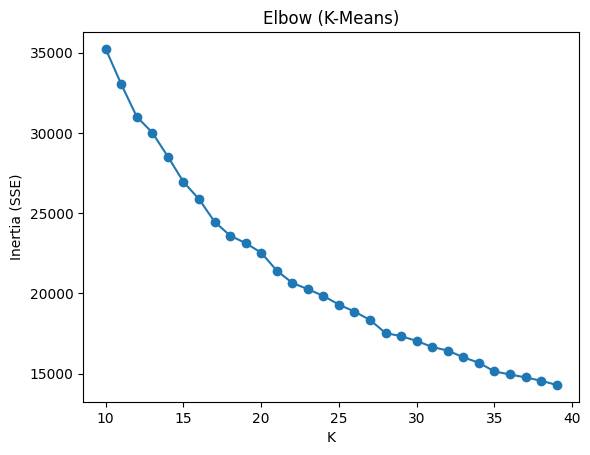

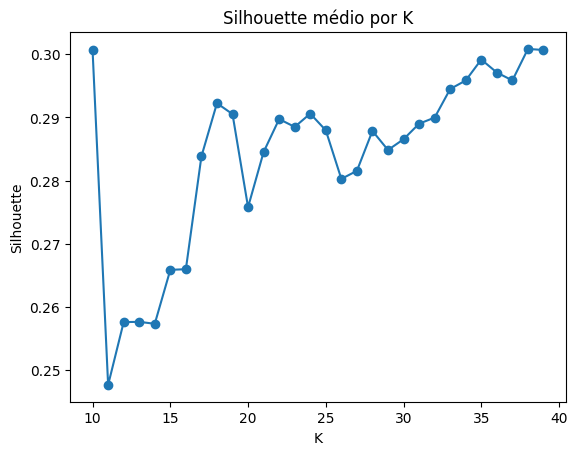

K* escolhido (silhouette): 38

Métricas internas:
K-Means     : {'silhouette': 0.3008359247577801, 'calinski_harabasz': 626.1701862839566, 'davies_bouldin': 1.122322845850642}
HAC - ward : {'silhouette': 0.30616205026949506, 'calinski_harabasz': 648.3451703656115, 'davies_bouldin': 1.126009762009092}
HAC - complete: {'silhouette': 0.26550912192251547, 'calinski_harabasz': 526.2943686714797, 'davies_bouldin': 1.0745878592677602}

MyScore:
K-Means     : 5.989542687172864
HAC - ward : 6.027879603518505
HAC - complete: 5.80350557693343


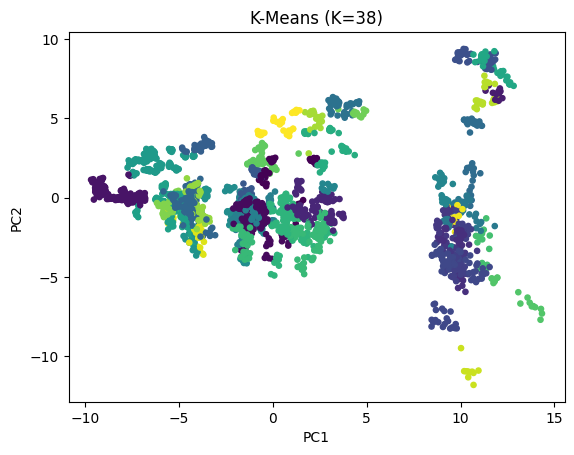

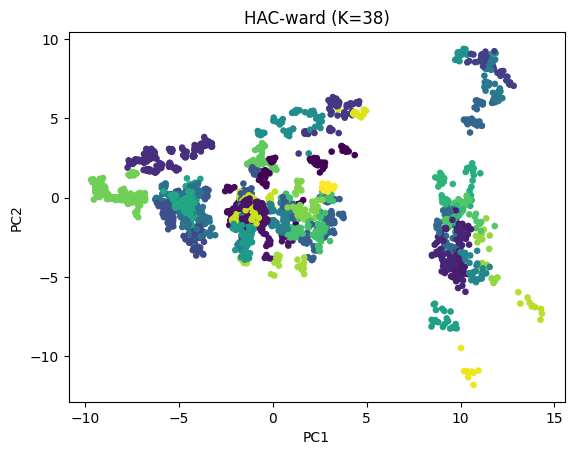

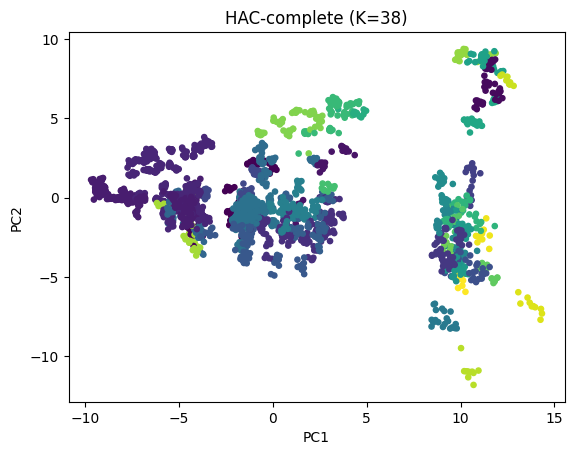

In [18]:

# X2: já está só com features após seu drop acima
X2 = resultados.copy()

# Se ainda existirem categóricas, tratamos aqui; caso não haja, isso continua funcionando
num_cols = X2.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X2.columns if c not in num_cols]

preprocess_unsup = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("scaler", RobustScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_cols)
    ],
    remainder="drop"
)

# (Opcional) PCA só para reduzir dimensão e facilitar distância/plot (ajuste a fração/qtde se quiser)
dimred = PCA(n_components=0.95, random_state=0)  # mantém 95% da variância

prep = Pipeline([
    ("prep", preprocess_unsup),
    ("pca", dimred)
])

Z = prep.fit_transform(X2)
print("Matriz final para clustering:", Z.shape)

# ----- Elbow + Silhouette para escolher K -----
Ks = range(10, 40)
inertias = []
sils = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=0)
    km.fit(Z)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(Z, km.labels_))

# Plot cotovelo
plt.figure()
plt.plot(list(Ks), inertias, marker="o")
plt.xlabel("K"); plt.ylabel("Inertia (SSE)"); plt.title("Elbow (K-Means)")
plt.show()

# Plot silhouette médio por K (ajuda a confirmar o K do cotovelo)
plt.figure()
plt.plot(list(Ks), sils, marker="o")
plt.xlabel("K"); plt.ylabel("Silhouette"); plt.title("Silhouette médio por K")
plt.show()

# Escolha automática simples: K que maximiza silhouette
k_star = int(Ks[np.argmax(sils)])
print("K* escolhido (silhouette):", k_star)

# ----- Rodando K-Means com K* -----
km = KMeans(n_clusters=k_star, n_init="auto", random_state=0).fit(Z)
labels_km = km.labels_

# ----- Hierárquico com dois linkages (mesmo K*) -----
hac_ward     = AgglomerativeClustering(n_clusters=k_star, linkage="ward").fit(Z)
hac_complete = AgglomerativeClustering(n_clusters=k_star, linkage="complete").fit(Z)
labels_hw = hac_ward.labels_
labels_hc = hac_complete.labels_

def eval_clust(Xemb, labels):
    return {
        "silhouette": silhouette_score(Xemb, labels),
        "calinski_harabasz": calinski_harabasz_score(Xemb, labels),
        "davies_bouldin": davies_bouldin_score(Xemb, labels),
    }

print("\nMétricas internas:")
print("K-Means     :", eval_clust(Z, labels_km))
print("HAC - ward :", eval_clust(Z, labels_hw))
print("HAC - complete:", eval_clust(Z, labels_hc))

# ----- Medida própria (combina métricas internas) -----
def my_cluster_score(Xemb, labels):
    s  = silhouette_score(Xemb, labels)                    # maior é melhor
    ch = calinski_harabasz_score(Xemb, labels)             # maior é melhor
    db = davies_bouldin_score(Xemb, labels)                # menor é melhor
    return (s + np.log1p(ch)) - np.log1p(db)               # simples e estável
print("\nMyScore:")
print("K-Means     :", my_cluster_score(Z, labels_km))
print("HAC - ward :", my_cluster_score(Z, labels_hw))
print("HAC - complete:", my_cluster_score(Z, labels_hc))

# ----- Visualização 2D dos clusters (usando as 2 primeiras componentes já do PCA acima) -----
def plot_clusters_2d(X2d, labels, title):
    plt.figure()
    plt.scatter(X2d[:,0], X2d[:,1], c=labels, s=14)
    plt.title(title); plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()

Z2d = Z[:, :2] if Z.shape[1] >= 2 else np.c_[Z, np.zeros_like(Z)]
plot_clusters_2d(Z2d, labels_km, f"K-Means (K={k_star})")
plot_clusters_2d(Z2d, labels_hw, f"HAC-ward (K={k_star})")
plot_clusters_2d(Z2d, labels_hc, f"HAC-complete (K={k_star})")

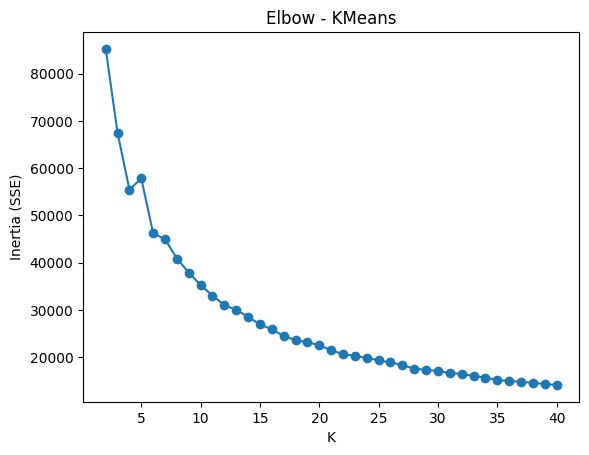

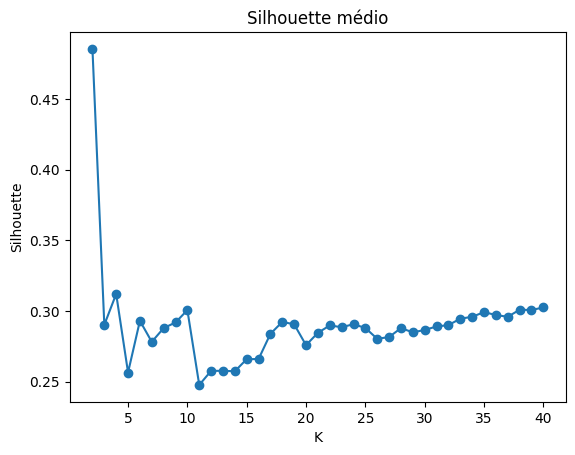

K* (cotovelo): 12

Métricas internas:
KMeans: {'silhouette': 0.2575935448745189, 'calinski_harabasz': 880.1884575600236, 'davies_bouldin': 1.3332673133290809}
HAC-ward: {'silhouette': 0.250399194102898, 'calinski_harabasz': 832.9702562501748, 'davies_bouldin': 1.352076667044754}
HAC-complete: {'silhouette': 0.25757927469738473, 'calinski_harabasz': 556.950235577682, 'davies_bouldin': 1.1436477298368026}

Medida própria (MyScore):
KMeans: 6.1915954954701355
HAC-ward: 6.1212983058192965
HAC-complete: 5.819340124953504


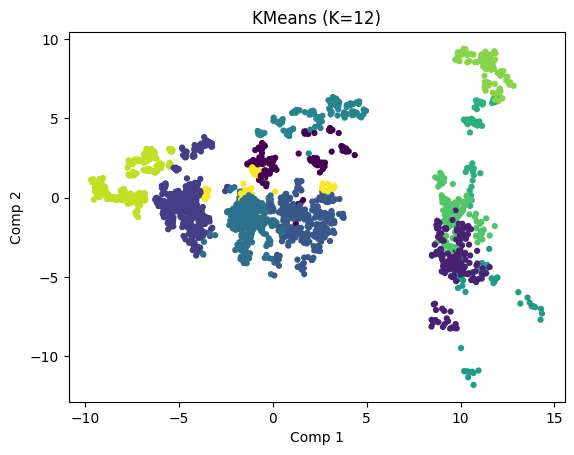

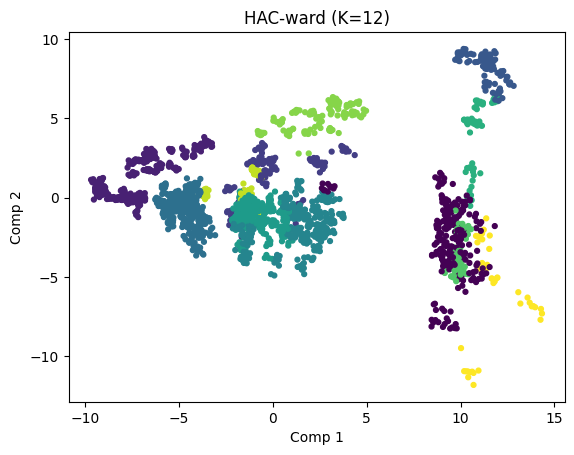

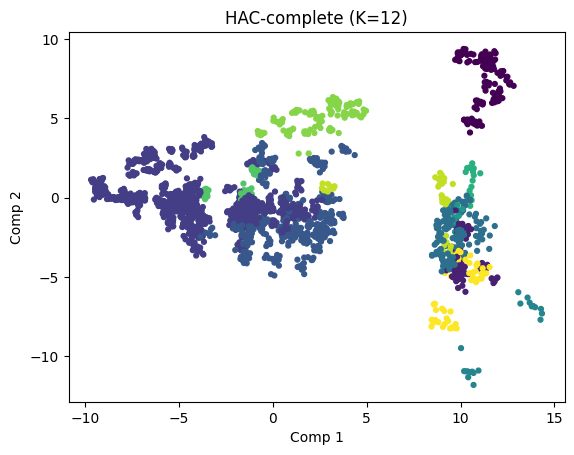

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Z: matriz de features já pré-processada (imputer/escala/[opcional PCA])

# --- 1) Varredura de K e curvas para o cotovelo ---
Ks = list(range(2, 41))  # ajuste se precisar
inertias = []
sil_means = []

for k in Ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=0).fit(Z)
    inertias.append(km.inertia_)
    sil_means.append(silhouette_score(Z, km.labels_))

plt.figure(); plt.plot(Ks, inertias, marker='o'); plt.xlabel('K'); plt.ylabel('Inertia (SSE)'); plt.title('Elbow - KMeans'); plt.show()
plt.figure(); plt.plot(Ks, sil_means, marker='o'); plt.xlabel('K'); plt.ylabel('Silhouette'); plt.title('Silhouette médio'); plt.show()

# --- 2) Escolha de K* pelo cotovelo (maior distância à reta extremos) ---
x1, y1 = Ks[0], inertias[0]
x2, y2 = Ks[-1], inertias[-1]
# distância perpendicular ponto->reta
dist = []
for k, y0 in zip(Ks, inertias):
    num = abs((y2 - y1)*k - (x2 - x1)*y0 + x2*y1 - y2*x1)
    den = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    dist.append(num/den)
k_star = Ks[int(np.argmax(dist))]
print(f"K* (cotovelo): {k_star}")

# --- 3) K-Means com K* ---
km = KMeans(n_clusters=k_star, n_init="auto", random_state=0).fit(Z)
labels_km = km.labels_

# --- 4) Hierárquico com o MESMO K* (dois linkages) ---
hac_ward     = AgglomerativeClustering(n_clusters=k_star, linkage='ward').fit(Z)
hac_complete = AgglomerativeClustering(n_clusters=k_star, linkage='complete').fit(Z)
labels_hw = hac_ward.labels_
labels_hc = hac_complete.labels_

# --- 5) Métricas internas e medida própria ---
def eval_clust(X, labels):
    return {
        "silhouette": silhouette_score(X, labels),
        "calinski_harabasz": calinski_harabasz_score(X, labels),
        "davies_bouldin": davies_bouldin_score(X, labels)
    }

def my_cluster_score(X, labels):
    s  = silhouette_score(X, labels)              # ↑ melhor
    ch = calinski_harabasz_score(X, labels)       # ↑ melhor
    db = davies_bouldin_score(X, labels)          # ↓ melhor
    return (s + np.log1p(ch)) - np.log1p(db)

print("\nMétricas internas:")
print("KMeans:", eval_clust(Z, labels_km))
print("HAC-ward:", eval_clust(Z, labels_hw))
print("HAC-complete:", eval_clust(Z, labels_hc))

print("\nMedida própria (MyScore):")
print("KMeans:", my_cluster_score(Z, labels_km))
print("HAC-ward:", my_cluster_score(Z, labels_hw))
print("HAC-complete:", my_cluster_score(Z, labels_hc))

# Visual 2D rápido (se Z tiver >=2 dims; usa as 2 primeiras componentes)
Z2d = Z[:, :2] if Z.shape[1] >= 2 else np.c_[Z, np.zeros_like(Z)]
for name, labels in [("KMeans", labels_km), ("HAC-ward", labels_hw), ("HAC-complete", labels_hc)]:
    plt.figure()
    plt.scatter(Z2d[:,0], Z2d[:,1], c=labels, s=12)
    plt.title(f"{name} (K={k_star})"); plt.xlabel("Comp 1"); plt.ylabel("Comp 2")
    plt.show()


Z shape: (2490, 96)
Z after corr filter: (2490, 38)


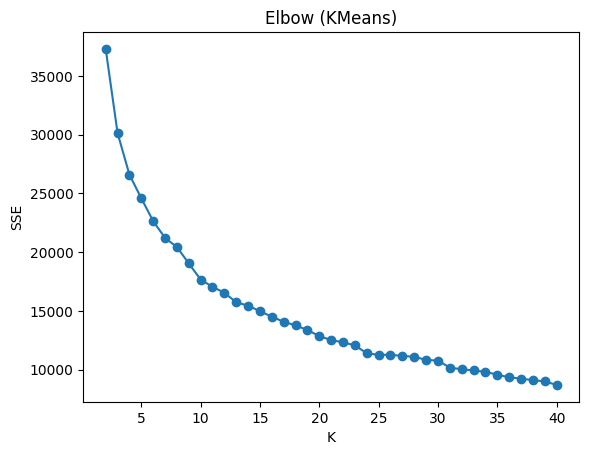

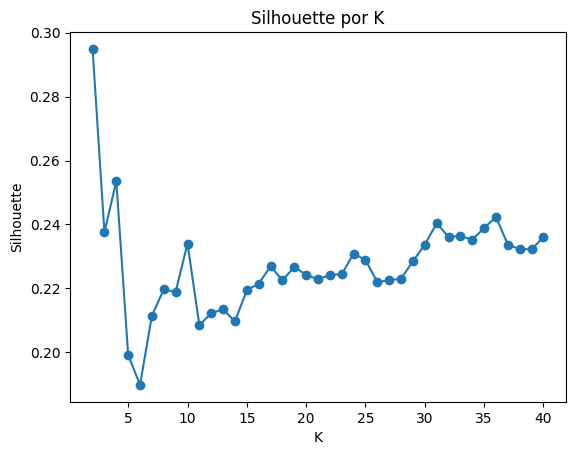

K* (cotovelo): 10

Métricas internas:
KMeans      : {'silhouette': 0.23403859265163754, 'CH': 596.6458849309801, 'DB': 1.4614436013441887} MyScore: 5.726
HAC-ward    : {'silhouette': 0.2091240063104804, 'CH': 556.577918384305, 'DB': 1.5942273175673165} MyScore: 5.579
HAC-avgCos  : {'silhouette': 0.23539627703775556, 'CH': 379.06255971374435, 'DB': 1.435898021569232} MyScore: 5.285


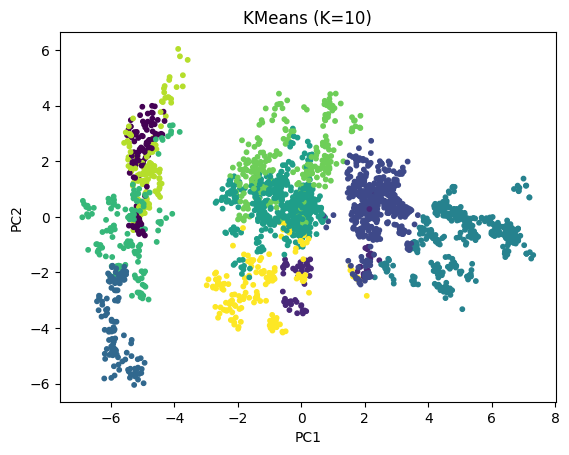

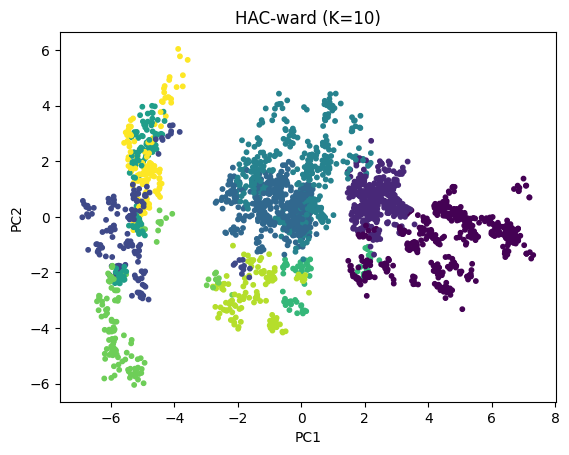

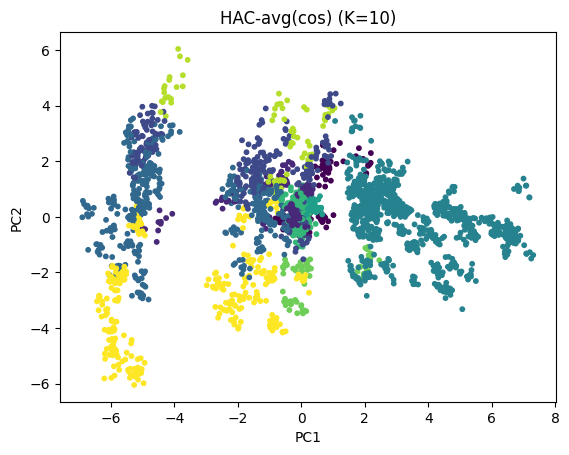

In [20]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, RobustScaler, Normalizer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans, AgglomerativeClustering

# ===== PREPROCESS enxuto (sem PCA para clusterizar) =====
def build_prep(var_thresh=1e-4):
    return Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("pow", PowerTransformer(method="yeo-johnson", standardize=False)),
        ("sc", RobustScaler()),
        ("vt", VarianceThreshold(threshold=var_thresh)),
    ])

prep = build_prep()
Z = prep.fit_transform(X2.values)   # X2 = seu DataFrame só de features
print("Z shape:", Z.shape)

# remove colunas altamente correlacionadas (no espaço já escalado)
def drop_high_corr(Z, thr=0.98):
    C = np.corrcoef(Z, rowvar=False)
    keep = np.ones(C.shape[0], dtype=bool)
    for i in range(C.shape[0]):
        if keep[i]:
            keep[(np.abs(C[i])>thr) & (np.arange(C.shape[0])>i)] = False
    return Z[:, keep]
Z = drop_high_corr(Z, thr=0.98)
print("Z after corr filter:", Z.shape)

# ===== Elbow + K* (mesmo esquema) =====
Ks = list(range(2, 41))
inertias, sils = [], []
for k in Ks:
    km = KMeans(n_clusters=k, n_init="auto", random_state=0).fit(Z)
    inertias.append(km.inertia_)
    sils.append(silhouette_score(Z, km.labels_))
plt.figure(); plt.plot(Ks, inertias, "o-"); plt.title("Elbow (KMeans)"); plt.xlabel("K"); plt.ylabel("SSE"); plt.show()
plt.figure(); plt.plot(Ks, sils, "o-"); plt.title("Silhouette por K"); plt.xlabel("K"); plt.ylabel("Silhouette"); plt.show()

# cotovelo (distância à reta dos extremos)
x1,y1=Ks[0],inertias[0]; x2,y2=Ks[-1],inertias[-1]
dist=[abs((y2-y1)*k-(x2-x1)*y+x2*y1-y2*x1)/np.sqrt((y2-y1)**2+(x2-x1)**2) for k,y in zip(Ks,inertias)]
k_star = Ks[int(np.argmax(dist))]
print("K* (cotovelo):", k_star)

# ===== KMeans (euclidiana) =====
km = KMeans(n_clusters=k_star, n_init="auto", random_state=0).fit(Z)
labels_km = km.labels_

# ===== Hierárquico: ward (euclidiana) e average (cosine) =====
hac_ward = AgglomerativeClustering(n_clusters=k_star, linkage="ward").fit(Z)
labels_hw = hac_ward.labels_

# cosine precisa normalizar vetores (spherical-like)
Z_cos = Normalizer(norm="l2").fit_transform(Z)
hac_avg_cos = AgglomerativeClustering(n_clusters=k_star, linkage="average", metric="cosine").fit(Z_cos)
labels_hc = hac_avg_cos.labels_

def eval_int(X, y):
    return {
        "silhouette": silhouette_score(X, y),
        "CH": calinski_harabasz_score(X, y),
        "DB": davies_bouldin_score(X, y)
    }
def myscore(X,y):
    s=silhouette_score(X,y); ch=calinski_harabasz_score(X,y); db=davies_bouldin_score(X,y)
    return (s + np.log1p(ch)) - np.log1p(db)

print("\nMétricas internas:")
print("KMeans      :", eval_int(Z, labels_km), "MyScore:", round(myscore(Z, labels_km),3))
print("HAC-ward    :", eval_int(Z, labels_hw), "MyScore:", round(myscore(Z, labels_hw),3))
print("HAC-avgCos  :", eval_int(Z_cos, labels_hc), "MyScore:", round(myscore(Z_cos, labels_hc),3))

# ===== Plot 2D só para visual (PCA APENAS para plot) =====
p2 = PCA(n_components=2, random_state=0).fit_transform(Z)
for name, lab in [("KMeans",labels_km), ("HAC-ward",labels_hw), ("HAC-avg(cos)",labels_hc)]:
    plt.figure()
    plt.scatter(p2[:,0], p2[:,1], c=lab, s=10)
    plt.title(f"{name} (K={k_star})"); plt.xlabel("PC1"); plt.ylabel("PC2")
    plt.show()


## Método do cotovelo para K-means

Calcula o SSE (inertia) para vários valores de K e seleciona-se o K no "cotovelo" do gráfico. Em seguida, roda-se K-means com esse K. Também computaremos métricas de qualidade de clusterização: Silhouette, Calinski-Harabasz e Davies-Bouldin.


In [ ]:
# Teste do cotovelo
K_MIN, K_MAX = 2, 12
inertias = []
Ks = list(range(K_MIN, K_MAX + 1))
for k in Ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    km.fit(X_proc)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(Ks, inertias, marker='o')
plt.xlabel('K')
plt.ylabel('Inertia (SSE)')
plt.title('Método do Cotovelo - KMeans')
plt.grid(True)
plt.show()

# Escolha do K: ajuste manualmente com base no cotovelo
K_CHOSEN = 4  # ajuste após visualizar o gráfico
print('K escolhido:', K_CHOSEN)


In [ ]:
# KMeans com K escolhido
kmeans = KMeans(n_clusters=K_CHOSEN, n_init=10, random_state=RANDOM_STATE)
labels_kmeans = kmeans.fit_predict(X_proc)

sil_km = silhouette_score(X_proc, labels_kmeans)
ch_km = calinski_harabasz_score(X_proc, labels_kmeans)
db_km = davies_bouldin_score(X_proc, labels_kmeans)

print(f'Silhouette (KMeans): {sil_km:.4f}')
print(f'Calinski-Harabasz (KMeans): {ch_km:.2f}')
print(f'Davies-Bouldin (KMeans): {db_km:.4f}')


## Clusterização Hierárquica

Rodaremos `AgglomerativeClustering` com o mesmo K escolhido no cotovelo e variaremos dois métodos de linkage (por exemplo, `ward` e `complete`), comparando as métricas com o K-means.


In [ ]:
def avaliar_clusterizacao(labels, nome):
    sil = silhouette_score(X_proc, labels)
    ch = calinski_harabasz_score(X_proc, labels)
    db = davies_bouldin_score(X_proc, labels)
    print(f"\n{nome}")
    print(f"Silhouette: {sil:.4f}")
    print(f"Calinski-Harabasz: {ch:.2f}")
    print(f"Davies-Bouldin: {db:.4f}")

# Dois linkages para comparar
for linkage in ['ward', 'complete']:
    # 'ward' requer métrica euclidiana
    if linkage == 'ward':
        model = AgglomerativeClustering(n_clusters=K_CHOSEN, linkage=linkage)
    else:
        model = AgglomerativeClustering(n_clusters=K_CHOSEN, linkage=linkage, metric='euclidean')

    labels_hier = model.fit_predict(X_proc)
    avaliar_clusterizacao(labels_hier, f'Hierárquico ({linkage})')


## Comparação e Métrica Própria

Além das métricas clássicas, podemos adotar uma métrica composta simples para ranquear as soluções: maximize `silhouette` e `calinski-harabasz`, minimize `davies-bouldin`. Uma proposta: score = z(silhouette) + z(calinski) - z(davies). Abaixo, exemplificamos como calcular e comparar para K-means e Hierárquico.


In [ ]:
from sklearn.preprocessing import StandardScaler as _Std

# Coletar métricas
results = []
results.append({'alg':'KMeans', 'sil': sil_km, 'ch': ch_km, 'db': db_km})

# Recalcular para hierárquicos com os mesmos linkages para registrar
scores_hier = {}
for linkage in ['ward', 'complete']:
    if linkage == 'ward':
        model = AgglomerativeClustering(n_clusters=K_CHOSEN, linkage=linkage)
    else:
        model = AgglomerativeClustering(n_clusters=K_CHOSEN, linkage=linkage, metric='euclidean')
    labels = model.fit_predict(X_proc)
    scores_hier[linkage] = {
        'sil': silhouette_score(X_proc, labels),
        'ch': calinski_harabasz_score(X_proc, labels),
        'db': davies_bouldin_score(X_proc, labels)
    }
    results.append({'alg': f'Hier({linkage})', **scores_hier[linkage]})

# Score composto (z-normalizado)
df_res = pd.DataFrame(results)
scaler = _Std()
z_sil = scaler.fit_transform(df_res[['sil']]).ravel()
z_ch  = scaler.fit_transform(df_res[['ch']]).ravel()
z_db  = scaler.fit_transform(df_res[['db']]).ravel()

df_res['score_composto'] = z_sil + z_ch - z_db
print(df_res.sort_values('score_composto', ascending=False))
